In [107]:
# Cell [1] - FINAL CORRECT VERSION
# ============================================================================
# MASTER CARDIAC ULTRASOUND ANALYSIS SYSTEM: CAMUS, Cactus, EchoNet Pediatric
# ============================================================================

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from PIL import Image
from pathlib import Path
import cv2
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {DEVICE}")

# Dataset paths - CORRECTED FOR ECHONET
CAMUS_DIR = "database_nifti"
CACTUS_DIR = "Cactus Dataset"

# FIXED: Correct absolute path for EchoNet
ECHONET_DIR = "/home/users/joshua04/141/data/raw/echonet_pediatric/A4C"

PANECHO_ROOT = "/home/users/joshua04/141/PanEcho"

sys.path.append(PANECHO_ROOT)
sys.path.append(os.path.join(PANECHO_ROOT, "src"))

print("✅ Environment setup complete")
print(f"\n📁 Dataset Paths:")
print(f"   CAMUS:   {CAMUS_DIR}")
print(f"   CACTUS:  {CACTUS_DIR}")
print(f"   ECHONET: {ECHONET_DIR}")

🖥️  Using device: cuda
✅ Environment setup complete

📁 Dataset Paths:
   CAMUS:   database_nifti
   CACTUS:  Cactus Dataset
   ECHONET: /home/users/joshua04/141/data/raw/echonet_pediatric/A4C


In [110]:
# Cell [2]
# ============================================================================
# CHOOSE DATASET TYPE
# ============================================================================

DATASET_TYPE = "ECHONET"      # Options: "CAMUS", "CACTUS"
print(f"📊 Selected analysis for: {DATASET_TYPE}")
print(f"✅ This dataset is available and ready!")

📊 Selected analysis for: ECHONET
✅ This dataset is available and ready!


In [111]:
# Cell [2.5]
# ============================================================================
# FIND AND VERIFY DATASET PATHS
# ============================================================================

print("🔍 Searching for datasets...\n")

# Check CAMUS
print("="*70)
print("CAMUS Dataset:")
print("="*70)
if os.path.exists(CAMUS_DIR):
    print(f"✅ Found: {CAMUS_DIR}")
    patients = [d for d in os.listdir(CAMUS_DIR) 
                if os.path.isdir(os.path.join(CAMUS_DIR, d)) and d.startswith('patient')]
    print(f"   Patients: {len(patients)}")
else:
    print(f"❌ Not found: {CAMUS_DIR}")

# Check CACTUS
print("\n" + "="*70)
print("CACTUS Dataset:")
print("="*70)
if os.path.exists(CACTUS_DIR):
    print(f"✅ Found: {CACTUS_DIR}")
    img_dir = os.path.join(CACTUS_DIR, "Images Dataset", "A4C")
    if os.path.exists(img_dir):
        images = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"   Images in A4C: {len(images)}")
    else:
        print(f"   ⚠️  Images Dataset/A4C not found")
        print(f"   Contents of {CACTUS_DIR}:")
        for item in os.listdir(CACTUS_DIR)[:10]:
            print(f"      - {item}")
else:
    print(f"❌ Not found: {CACTUS_DIR}")

# Check ECHONET - Let's search for the correct path
print("\n" + "="*70)
print("ECHONET Dataset:")
print("="*70)
print(f"Current path: {ECHONET_DIR}")

# Check if base directory exists
base_dir = "/home/users/joshua04/141/data/raw/echonet_pediatric"
if os.path.exists(base_dir):
    print(f"✅ Base directory exists: {base_dir}")
    print(f"\n📁 Contents of {base_dir}:")
    for item in os.listdir(base_dir):
        item_path = os.path.join(base_dir, item)
        if os.path.isdir(item_path):
            print(f"   📂 {item}/")
            # Check if Videos folder is inside
            videos_path = os.path.join(item_path, "Videos")
            if os.path.exists(videos_path):
                video_files = [f for f in os.listdir(videos_path) if f.endswith('.mp4')]
                print(f"      ✅ Videos/ found with {len(video_files)} .mp4 files")
            else:
                # List contents of subdirectory
                sub_contents = os.listdir(item_path)[:5]
                print(f"      Contents: {sub_contents}")
        else:
            print(f"   📄 {item}")
    
    # Try to find Videos folder
    print(f"\n🔍 Searching for Videos folder...")
    for root, dirs, files in os.walk(base_dir):
        if 'Videos' in dirs:
            videos_path = os.path.join(root, 'Videos')
            video_count = len([f for f in os.listdir(videos_path) if f.endswith('.mp4')])
            print(f"   ✅ Found Videos at: {videos_path}")
            print(f"      Video files: {video_count}")
            
            if video_count > 0:
                print(f"\n💡 UPDATE YOUR ECHONET_DIR in Cell [1] to:")
                print(f'   ECHONET_DIR = "{root}"')
                break
else:
    print(f"❌ Base directory not found: {base_dir}")
    print(f"\n💡 Please check your EchoNet installation path")

🔍 Searching for datasets...

CAMUS Dataset:
✅ Found: database_nifti
   Patients: 500

CACTUS Dataset:
✅ Found: Cactus Dataset
   Images in A4C: 7422

ECHONET Dataset:
Current path: /home/users/joshua04/141/data/raw/echonet_pediatric/A4C
✅ Base directory exists: /home/users/joshua04/141/data/raw/echonet_pediatric

📁 Contents of /home/users/joshua04/141/data/raw/echonet_pediatric:
   📂 A4C/
      ✅ Videos/ found with 0 .mp4 files
   📂 PSAX/
      ✅ Videos/ found with 0 .mp4 files

🔍 Searching for Videos folder...
   ✅ Found Videos at: /home/users/joshua04/141/data/raw/echonet_pediatric/A4C/Videos
      Video files: 0
   ✅ Found Videos at: /home/users/joshua04/141/data/raw/echonet_pediatric/PSAX/Videos
      Video files: 0


In [112]:
# Cell [3]
# ============================================================================
# MODEL 1: U-NET SEGMENTATION MODEL (CAMUS)
# ============================================================================

class UNet(nn.Module):
    """U-Net for cardiac segmentation (LV, Myocardium, LA)"""
    def __init__(self, in_channels=1, out_channels=4):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.bottleneck = self.conv_block(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        self.out = nn.Conv2d(64, out_channels, 1)
        self.pool = nn.MaxPool2d(2)
    
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.out(d1)

print("✅ U-Net segmentation model defined")

✅ U-Net segmentation model defined


In [113]:
# Cell [4]
# ============================================================================
# MODEL 2: CACTUS QUALITY ASSESSMENT MODEL
# ============================================================================

from torchvision.models import resnet18, ResNet18_Weights

class CactusQualityModel(nn.Module):
    """Multi-task model for ultrasound quality grading"""
    def __init__(self):
        super(CactusQualityModel, self).__init__()
        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        feat_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.grade_head = nn.Linear(feat_dim, 1)
        self.quality_head = nn.Linear(feat_dim, 3)
    
    def forward(self, x):
        features = self.backbone(x)
        grade = self.grade_head(features)
        quality_logits = self.quality_head(features)
        return grade, quality_logits

print("✅ Cactus quality assessment model defined")

✅ Cactus quality assessment model defined


In [114]:
# Cell [5]
# ============================================================================
# MODEL 3: ECHONET EF PREDICTION MODEL
# ============================================================================

from src.models import FrameTransformer

class EFPredictionModel(nn.Module):
    """Video-based EF prediction using FrameTransformer"""
    def __init__(self):
        super(EFPredictionModel, self).__init__()
        self.backbone = FrameTransformer(
            arch="convnext_tiny",
            n_heads=8,
            n_layers=2,
            transformer_dropout=0.1,
            pooling="mean",
            clip_len=16)
        self.fc = nn.Linear(768, 1)
    
    def forward(self, x):
        features = self.backbone(x)
        return self.fc(features)

print("✅ EF prediction model defined")

✅ EF prediction model defined


In [115]:
# Cell [6]
# ============================================================================
# LOAD PRETRAINED MODELS
# ============================================================================

def load_segment_model():
    """Load U-Net segmentation model"""
    model = UNet().to(DEVICE)
    path = "checkpoints/segmentation_model.pt"
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=DEVICE, weights_only=True))
        model.eval()
        print("✅ Segmentation model loaded")
        return model
    else:
        print("⚠️  Segmentation model not found")
        return None

def load_cactus_model():
    """Load Cactus quality assessment model"""
    model = CactusQualityModel().to(DEVICE)
    path = "cactus_pretrain_5epochs.pt"
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=DEVICE, weights_only=True))
        model.eval()
        print("✅ Cactus quality model loaded")
        return model
    else:
        print("⚠️  Cactus quality model not found")
        return None

def load_ef_model():
    """Load EchoNet EF prediction model"""
    model = EFPredictionModel().to(DEVICE)
    path = "/home/users/joshua04/141/results/ef_frozen_head.pt"
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=DEVICE, weights_only=True)
        new_state_dict = {}
        for key, value in checkpoint.items():
            if key.startswith("0."):
                new_key = "backbone." + key[2:]
            elif key.startswith("1."):
                new_key = "fc." + key[2:]
            else:
                new_key = key
            new_state_dict[new_key] = value
        model.load_state_dict(new_state_dict)
        model.eval()
        print("✅ EF prediction model loaded")
        return model
    else:
        print("⚠️  EF model not found")
        return None

# Load all models
seg_model = load_segment_model()
cactus_model = load_cactus_model()
ef_model = load_ef_model()

✅ Segmentation model loaded
✅ Cactus quality model loaded
✅ EF prediction model loaded


In [116]:
# Cell [7]
# ============================================================================
# CAMUS UTILITY FUNCTIONS
# ============================================================================

def explore_camus(data_dir):
    """Explore CAMUS dataset structure"""
    if not os.path.exists(data_dir):
        print(f"❌ Directory {data_dir} not found!")
        return []
    patients = sorted([d for d in os.listdir(data_dir)
                      if os.path.isdir(os.path.join(data_dir, d)) and d.startswith('patient')])
    print(f"📊 Found {len(patients)} patients in CAMUS")
    return patients

def load_image(pid, view="2CH", phase="ED", data_dir=CAMUS_DIR):
    """Load cardiac image"""
    path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}.nii.gz")
    if not os.path.exists(path):
        return None
    return nib.load(path).get_fdata()

def load_mask(pid, view="2CH", phase="ED", data_dir=CAMUS_DIR):
    """Load segmentation mask"""
    path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}_gt.nii.gz")
    if not os.path.exists(path):
        return None
    return nib.load(path).get_fdata()

def lv_area_mm2(pid, view="2CH", phase="ED", data_dir=CAMUS_DIR):
    """Calculate LV cavity area in mm²"""
    img_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}.nii.gz")
    mask_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}_gt.nii.gz")
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        return None
    img_nii = nib.load(img_path)
    mask = nib.load(mask_path).get_fdata()
    dx, dy = img_nii.header.get_zooms()[:2]
    lv_pixels = (mask == 1).sum()
    return lv_pixels * dx * dy

def lv_length_mm(pid, view="4CH", phase="ED", data_dir=CAMUS_DIR):
    """Calculate LV long-axis length in mm"""
    img_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}.nii.gz")
    mask_path = os.path.join(data_dir, pid, f"{pid}_{view}_{phase}_gt.nii.gz")
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        return None
    img_nii = nib.load(img_path)
    mask = nib.load(mask_path).get_fdata()
    dx, dy = img_nii.header.get_zooms()[:2]
    ys, xs = np.where(mask == 1)
    if len(xs) == 0:
        return None
    length_pixels = np.sqrt((xs.max() - xs.min()) ** 2 + (ys.max() - ys.min()) ** 2)
    return length_pixels * np.mean([dx, dy])

def lv_volume_ml(pid, phase="ED", data_dir=CAMUS_DIR):
    """Calculate LV volume in mL using biplane area-length method"""
    A_2ch = lv_area_mm2(pid, "2CH", phase, data_dir)
    A_4ch = lv_area_mm2(pid, "4CH", phase, data_dir)
    L = lv_length_mm(pid, "4CH", phase, data_dir)
    if None in [A_2ch, A_4ch, L]:
        return None
    V_mm3 = (8 / (3 * np.pi)) * (A_2ch * A_4ch) / L
    return V_mm3 / 1000

def calculate_cardiac_metrics(pid, data_dir=CAMUS_DIR):
    """Calculate comprehensive cardiac metrics"""
    edv = lv_volume_ml(pid, "ED", data_dir)
    esv = lv_volume_ml(pid, "ES", data_dir)
    if None in [edv, esv]:
        return None
    sv = edv - esv
    ef = (sv / edv) * 100
    return {"EDV": edv, "ESV": esv, "SV": sv, "EF": ef}

def cardiac_output_L_min(sv_ml, hr_bpm):
    """Calculate Cardiac Output in L/min"""
    return (sv_ml * hr_bpm) / 1000

print("✅ CAMUS utility functions loaded")

✅ CAMUS utility functions loaded


In [117]:
# Cell [8] - UPDATE read_video_frames to handle .avi files
# ============================================================================
# CROSS-DATASET UTILITY FUNCTIONS - UPDATED FOR .AVI
# ============================================================================

from torchvision import transforms
import torchvision.transforms.functional as TF

def extract_frame_from_video(video_path, frame_idx=0):
    """Extract a single frame from video (.avi or .mp4) as grayscale for segmentation"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        return None
    
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return gray

def preprocess_for_segmentation(img_array, target_size=(256, 256)):
    """
    Preprocess any image (from video frame, CAMUS, or Cactus) for U-Net segmentation
    Input: numpy array (H, W) grayscale or (H, W, 3) color
    Output: torch tensor (1, 1, H, W) normalized
    """
    # Convert to grayscale if color
    if len(img_array.shape) == 3:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    # Normalize to [0, 1]
    img_norm = (img_array - img_array.min()) / (img_array.max() - img_array.min() + 1e-8)
    
    # Convert to PIL Image for transform
    img_pil = Image.fromarray((img_norm * 255).astype(np.uint8))
    
    # Resize
    img_resized = TF.resize(img_pil, target_size, interpolation=Image.BILINEAR)
    
    # To tensor
    img_tensor = TF.to_tensor(img_resized)
    
    return img_tensor.unsqueeze(0)  # (1, 1, H, W)

def segment_image(model, img_tensor):
    """
    Run segmentation on preprocessed image tensor
    Returns: segmentation mask as numpy array
    """
    if model is None:
        return None
    
    with torch.no_grad():
        img_tensor = img_tensor.to(DEVICE)
        output = model(img_tensor)
        pred_mask = torch.argmax(output, dim=1).cpu().numpy()[0]
    
    return pred_mask

def calculate_metrics_from_mask(mask, pixel_spacing_mm=(1.0, 1.0)):
    """
    Calculate cardiac metrics from segmentation mask
    mask: 2D numpy array with labels (0=background, 1=LV, 2=myocardium, 3=LA)
    pixel_spacing_mm: (dx, dy) in mm
    """
    dx, dy = pixel_spacing_mm
    pixel_area_mm2 = dx * dy
    
    # LV area
    lv_pixels = (mask == 1).sum()
    lv_area = lv_pixels * pixel_area_mm2
    
    # LV length (approximation)
    ys, xs = np.where(mask == 1)
    if len(xs) == 0:
        return None
    
    lv_length = np.sqrt((xs.max() - xs.min()) ** 2 + (ys.max() - ys.min()) ** 2) * np.mean([dx, dy])
    
    return {
        "lv_area_mm2": lv_area,
        "lv_length_mm": lv_length,
        "lv_pixels": lv_pixels
    }

def preprocess_for_quality(img_array, is_video_frame=False):
    """
    Preprocess image for Cactus quality model
    Input: numpy array (H, W) grayscale or (H, W, 3) RGB
    Output: torch tensor (1, 3, 224, 224)
    """
    # Convert grayscale to RGB if needed
    if len(img_array.shape) == 2:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif img_array.shape[2] == 1:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    
    # Convert to PIL
    img_pil = Image.fromarray(img_array.astype(np.uint8))
    
    # Transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    img_tensor = transform(img_pil).unsqueeze(0)
    return img_tensor

def assess_quality(model, img_tensor):
    """
    Assess image quality using Cactus model
    Returns: dict with grade, quality label, and confidence
    """
    if model is None:
        return None
    
    QUALITY_LABELS = ["Bad", "Okay", "Good"]
    
    with torch.no_grad():
        img_tensor = img_tensor.to(DEVICE)
        pred_grade, pred_quality = model(img_tensor)
        grade = float(torch.clamp(pred_grade, 1.0, 10.0).item())
        probs = torch.softmax(pred_quality, dim=1)
        conf, cls = torch.max(probs, dim=1)
    
    return {
        "grade": round(grade),
        "quality": QUALITY_LABELS[cls.item()],
        "confidence": conf.item()
    }

def read_video_frames_for_ef(path, n_frames=16):
    """Extract frames from video (.avi or .mp4) for EF prediction"""
    import torchvision.transforms as T
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        return None
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, max(length - 1, 0), n_frames).astype(int)
    
    frames = []
    i = 0
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        if i in idxs:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(transform(frame))
        i += 1
    cap.release()
    
    while len(frames) < n_frames:
        frames.append(frames[-1])
    
    return torch.stack(frames, dim=1)  # (3, T, 224, 224)

def predict_ef(model, video_tensor):
    """Predict EF from video tensor"""
    if model is None:
        return None
    
    with torch.no_grad():
        video_tensor = video_tensor.unsqueeze(0).to(DEVICE)
        ef = model(video_tensor)
    
    return ef.item()

print("✅ Cross-dataset utility functions loaded")

✅ Cross-dataset utility functions loaded


In [144]:
# Cell [9] - UPDATED FOR .AVI FILES
# ============================================================================
# UNIFIED ANALYSIS: ALL MODELS ON SELECTED DATASET
# ============================================================================

def analyze_camus_complete():
    """Run all analyses on CAMUS dataset"""
    print("\n" + "="*70)
    print("🫀 COMPREHENSIVE CAMUS ANALYSIS")
    print("="*70 + "\n")
    
    patients = explore_camus(CAMUS_DIR)
    if not patients:
        return None
    
    results = []
    
    for pid in patients[:5]:
        print(f"\n{'='*70}")
        print(f"Analyzing {pid}")
        print(f"{'='*70}")
        
        # 1. Cardiac Metrics (from ground truth masks)
        metrics = calculate_cardiac_metrics(pid, CAMUS_DIR)
        
        if metrics:
            print(f"\n📊 Cardiac Metrics (Ground Truth):")
            print(f"  EDV: {metrics['EDV']:.1f} mL")
            print(f"  ESV: {metrics['ESV']:.1f} mL")
            print(f"  SV:  {metrics['SV']:.1f} mL")
            print(f"  EF:  {metrics['EF']:.1f}%")
            co = cardiac_output_L_min(metrics['SV'], 75)
            print(f"  CO:  {co:.2f} L/min (@ 75 bpm)")
        
        # 2. Segmentation (predict with U-Net on 4CH ED)
        seg_metrics = None
        if seg_model is not None:
            img = load_image(pid, "4CH", "ED", CAMUS_DIR)
            if img is not None:
                img_tensor = preprocess_for_segmentation(img)
                pred_mask = segment_image(seg_model, img_tensor)
                seg_metrics = calculate_metrics_from_mask(pred_mask, pixel_spacing_mm=(1.5, 1.5))
                
                print(f"\n🔍 Segmentation Metrics (U-Net Prediction):")
                if seg_metrics:
                    print(f"  LV Area: {seg_metrics['lv_area_mm2']:.1f} mm²")
                    print(f"  LV Length: {seg_metrics['lv_length_mm']:.1f} mm")
        
        # 3. Quality Assessment
        quality_result = None
        if cactus_model is not None:
            img = load_image(pid, "4CH", "ED", CAMUS_DIR)
            if img is not None:
                # Convert to RGB for quality model
                img_rgb = np.stack([img]*3, axis=-1)
                img_rgb = ((img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min() + 1e-8) * 255).astype(np.uint8)
                quality_tensor = preprocess_for_quality(img_rgb)
                quality_result = assess_quality(cactus_model, quality_tensor)
                
                print(f"\n⭐ Image Quality Assessment:")
                if quality_result:
                    print(f"  Quality: {quality_result['quality']}")
                    print(f"  Grade: {quality_result['grade']}/10")
                    print(f"  Confidence: {quality_result['confidence']:.2%}")
        
        # Build result dictionary
        result = {"patient": pid, "dataset": "CAMUS"}
        
        if metrics:
            result.update(metrics)
        
        result["segmentation"] = seg_metrics
        result["quality"] = quality_result
        
        results.append(result)
    
    return results

def analyze_cactus_complete():
    """Run all analyses on Cactus dataset"""
    print("\n" + "="*70)
    print("🔍 COMPREHENSIVE CACTUS ANALYSIS")
    print("="*70 + "\n")
    
    image_dir = os.path.join(CACTUS_DIR, "Images Dataset", "A4C")
    if not os.path.exists(image_dir):
        print(f"❌ Directory not found: {image_dir}")
        return None
    
    image_files = [os.path.join(image_dir, f)
                   for f in os.listdir(image_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]
    
    results = []
    
    for img_path in image_files:
        print(f"\n{'='*70}")
        print(f"Analyzing {os.path.basename(img_path)}")
        print(f"{'='*70}")
        
        # Load image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 1. Quality Assessment (primary task for Cactus)
        quality_result = None
        if cactus_model is not None:
            quality_tensor = preprocess_for_quality(img_rgb)
            quality_result = assess_quality(cactus_model, quality_tensor)
            
            print(f"\n⭐ Image Quality Assessment:")
            if quality_result:
                print(f"  Quality: {quality_result['quality']}")
                print(f"  Grade: {quality_result['grade']}/10")
                print(f"  Confidence: {quality_result['confidence']:.2%}")
        
        # 2. Segmentation (apply U-Net trained on CAMUS)
        seg_metrics = None
        if seg_model is not None:
            seg_tensor = preprocess_for_segmentation(img_gray)
            pred_mask = segment_image(seg_model, seg_tensor)
            seg_metrics = calculate_metrics_from_mask(pred_mask, pixel_spacing_mm=(0.5, 0.5))
            
            print(f"\n🔍 Segmentation Metrics (Cross-domain):")
            if seg_metrics:
                print(f"  LV Area: {seg_metrics['lv_area_mm2']:.1f} mm²")
                print(f"  LV Length: {seg_metrics['lv_length_mm']:.1f} mm")
                print(f"  Note: Metrics are approximate (trained on CAMUS)")
        
        result = {
            "image": os.path.basename(img_path),
            "dataset": "CACTUS",
            "quality": quality_result,
            "segmentation": seg_metrics
        }
        results.append(result)
    
    return results

def analyze_echonet_complete():
    """Run all analyses on EchoNet dataset - UPDATED FOR .AVI FILES"""
    print("\n" + "="*70)
    print("🎥 COMPREHENSIVE ECHONET ANALYSIS")
    print("="*70 + "\n")
    
    video_folder = os.path.join(ECHONET_DIR, "Videos")
    if not os.path.exists(video_folder):
        print(f"❌ Video folder not found: {video_folder}")
        return None
    
    # UPDATED: Look for .avi files (and .mp4 as backup)
    video_files = [os.path.join(video_folder, f)
                   for f in os.listdir(video_folder)
                   if f.endswith(('.avi', '.mp4'))][:3]
    
    if not video_files:
        print(f"❌ No video files (.avi or .mp4) found in {video_folder}")
        return None
    
    print(f"✅ Found {len(video_files)} videos")
    
    results = []
    
    for video_path in video_files:
        print(f"\n{'='*70}")
        print(f"Analyzing {os.path.basename(video_path)}")
        print(f"{'='*70}")
        
        # Check if video can be opened
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"⚠️  Could not open video: {video_path}")
            continue
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.release()
        
        if total_frames == 0:
            print(f"⚠️  Video has 0 frames: {video_path}")
            continue
        
        print(f"   Total frames: {total_frames}")
        print(f"   FPS: {fps:.1f}")
        
        # 1. EF Prediction (primary task for EchoNet)
        ef_value = None
        if ef_model is not None:
            try:
                print("\n💓 Running EF prediction...")
                video_tensor = read_video_frames_for_ef(video_path, n_frames=16)
                if video_tensor is not None:
                    ef_value = predict_ef(ef_model, video_tensor)
                    print(f"   Predicted EF: {ef_value:.2f}%")
                    
                    # Clinical interpretation
                    if ef_value >= 55:
                        print(f"   Status: ✅ Normal")
                    elif ef_value >= 50:
                        print(f"   Status: ⚠️  Borderline")
                    else:
                        print(f"   Status: ❌ Reduced")
            except Exception as e:
                print(f"   ⚠️  EF prediction failed: {e}")
        
        # 2. Quality Assessment (on middle frame)
        quality_result = None
        if cactus_model is not None:
            try:
                print("\n⭐ Assessing quality...")
                cap = cv2.VideoCapture(video_path)
                cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
                ret, frame = cap.read()
                cap.release()
                
                if ret:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    quality_tensor = preprocess_for_quality(frame_rgb, is_video_frame=True)
                    quality_result = assess_quality(cactus_model, quality_tensor)
                    
                    if quality_result:
                        print(f"   Quality: {quality_result['quality']}")
                        print(f"   Grade: {quality_result['grade']}/10")
                        print(f"   Confidence: {quality_result['confidence']:.2%}")
            except Exception as e:
                print(f"   ⚠️  Quality assessment failed: {e}")
        
        # 3. Segmentation (on middle frame)
        seg_metrics = None
        if seg_model is not None:
            try:
                print("\n🔍 Running segmentation...")
                frame_gray = extract_frame_from_video(video_path, frame_idx=total_frames // 2)
                if frame_gray is not None:
                    seg_tensor = preprocess_for_segmentation(frame_gray)
                    pred_mask = segment_image(seg_model, seg_tensor)
                    seg_metrics = calculate_metrics_from_mask(pred_mask, pixel_spacing_mm=(0.5, 0.5))
                    
                    if seg_metrics:
                        print(f"   LV Area: {seg_metrics['lv_area_mm2']:.1f} mm²")
                        print(f"   LV Length: {seg_metrics['lv_length_mm']:.1f} mm")
                        print(f"   ⚠️  Note: Cross-domain (trained on CAMUS)")
            except Exception as e:
                print(f"   ⚠️  Segmentation failed: {e}")
        
        result = {
            "video": os.path.basename(video_path),
            "video_path": video_path,
            "dataset": "ECHONET",
            "total_frames": total_frames,
            "fps": fps,
            "predicted_ef": ef_value,
            "quality": quality_result,
            "segmentation": seg_metrics
        }
        results.append(result)
    
    return results

# Initialize all_results as None
all_results = None

# Run comprehensive analysis based on selected dataset
print(f"\n🔄 Running analysis for {DATASET_TYPE} dataset...")

if DATASET_TYPE == "CAMUS":
    all_results = analyze_camus_complete()
elif DATASET_TYPE == "CACTUS":
    all_results = analyze_cactus_complete()
elif DATASET_TYPE == "ECHONET":
    all_results = analyze_echonet_complete()
else:
    print("❌ Invalid DATASET_TYPE. Choose 'CAMUS', 'CACTUS', or 'ECHONET'")

# Print completion status
if all_results:
    print(f"\n✅ Analysis complete! Analyzed {len(all_results)} samples.")
    print(f"💡 Now run the visualization cells (Cell 17-22) to see results!")
else:
    print(f"\n⚠️  No results generated. Check dataset path and try again.")


🔄 Running analysis for ECHONET dataset...

🎥 COMPREHENSIVE ECHONET ANALYSIS

✅ Found 3 videos

Analyzing CR32a95d7-CR32a9794-000046.avi
   Total frames: 264
   FPS: 50.0

💓 Running EF prediction...
   Predicted EF: 62.40%
   Status: ✅ Normal

⭐ Assessing quality...
   Quality: Bad
   Grade: 3/10
   Confidence: 44.69%

🔍 Running segmentation...

Analyzing CR3dca7da-CR3dcaa6a-000042.avi
   Total frames: 61
   FPS: 50.0

💓 Running EF prediction...
   Predicted EF: 61.82%
   Status: ✅ Normal

⭐ Assessing quality...
   Quality: Bad
   Grade: 3/10
   Confidence: 40.52%

🔍 Running segmentation...

Analyzing CR3dcb5a8-CR3dcb8a1-000033.avi
   Total frames: 194
   FPS: 50.0

💓 Running EF prediction...
   Predicted EF: 66.80%
   Status: ✅ Normal

⭐ Assessing quality...
   Quality: Bad
   Grade: 3/10
   Confidence: 67.20%

🔍 Running segmentation...

✅ Analysis complete! Analyzed 3 samples.
💡 Now run the visualization cells (Cell 17-22) to see results!


In [145]:
# Cell [10]
# ============================================================================
# VISUALIZATION: Segmentation Overlay
# ============================================================================

def visualize_segmentation_overlay(img_array, pred_mask, title="Segmentation Overlay"):
    """
    Visualize image with segmentation overlay
    img_array: original image (H, W) or (H, W, 3)
    pred_mask: predicted segmentation (H, W) with labels 0-3
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    if len(img_array.shape) == 2:
        axes[0].imshow(img_array, cmap='gray')
    else:
        axes[0].imshow(img_array)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Segmentation mask
    axes[1].imshow(pred_mask, cmap='jet')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')
    
    # Overlay
    if len(img_array.shape) == 2:
        axes[2].imshow(img_array, cmap='gray')
    else:
        axes[2].imshow(img_array)
    
    lv_mask = (pred_mask == 1).astype(float)
    myo_mask = (pred_mask == 2).astype(float)
    la_mask = (pred_mask == 3).astype(float)
    
    axes[2].imshow(lv_mask, alpha=0.4, cmap='Reds')
    axes[2].imshow(myo_mask, alpha=0.3, cmap='Blues')
    axes[2].imshow(la_mask, alpha=0.3, cmap='Greens')
    axes[2].set_title('Overlay (Red=LV, Blue=Myo, Green=LA)')
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✅ Visualization function loaded")

✅ Visualization function loaded


In [146]:
# Cell [11]
# ============================================================================
# EXAMPLE: Visualize Segmentation on EchoNet Frame
# ============================================================================

if DATASET_TYPE == "ECHONET" and seg_model is not None:
    video_folder = os.path.join(ECHONET_DIR, "Videos")
    if os.path.exists(video_folder):
        video_files = [os.path.join(video_folder, f)
                       for f in os.listdir(video_folder)
                       if f.endswith('.mp4')]
        
        if video_files:
            # Take first video
            video_path = video_files[0]
            
            # Extract middle frame
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
            ret, frame = cap.read()
            cap.release()
            
            if ret:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                
                # Segment
                seg_tensor = preprocess_for_segmentation(frame_gray)
                pred_mask = segment_image(seg_model, seg_tensor)
                
                # Visualize
                visualize_segmentation_overlay(
                    frame_gray, 
                    pred_mask, 
                    title=f"EchoNet Segmentation: {os.path.basename(video_path)}"
                )

In [147]:
# Cell [12]
# ============================================================================
# EXAMPLE: Visualize Segmentation on Cactus Image
# ============================================================================

if DATASET_TYPE == "CACTUS" and seg_model is not None:
    image_dir = os.path.join(CACTUS_DIR, "Images Dataset", "A4C")
    if os.path.exists(image_dir):
        image_files = [os.path.join(image_dir, f)
                       for f in os.listdir(image_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if image_files:
            # Take first image
            img_path = image_files[0]
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Segment
            seg_tensor = preprocess_for_segmentation(img_gray)
            pred_mask = segment_image(seg_model, seg_tensor)
            
            # Visualize
            visualize_segmentation_overlay(
                img_gray, 
                pred_mask, 
                title=f"Cactus Segmentation: {os.path.basename(img_path)}"
            )

In [148]:
# Cell [13]
# ============================================================================
# EXAMPLE: Visualize Segmentation on CAMUS Image
# ============================================================================

if DATASET_TYPE == "CAMUS" and seg_model is not None:
    patients = explore_camus(CAMUS_DIR)
    if patients:
        pid = patients[0]
        img = load_image(pid, "4CH", "ED", CAMUS_DIR)
        
        if img is not None:
            # Segment
            seg_tensor = preprocess_for_segmentation(img)
            pred_mask = segment_image(seg_model, seg_tensor)
            
            # Visualize
            visualize_segmentation_overlay(
                img, 
                pred_mask, 
                title=f"CAMUS Segmentation: {pid} 4CH ED"
            )

In [149]:
# Cell [14]
# ============================================================================
# SUMMARY STATISTICS ACROSS ALL ANALYSES
# ============================================================================

def print_summary_statistics(results):
    """Print comprehensive summary of all analyses"""
    if not results:
        print("No results to summarize")
        return
    
    print("\n" + "="*70)
    print("📊 COMPREHENSIVE ANALYSIS SUMMARY")
    print("="*70 + "\n")
    
    dataset = results[0].get("dataset", "Unknown")
    print(f"Dataset: {dataset}")
    print(f"Total analyzed: {len(results)}")
    
    # Quality statistics
    quality_results = [r.get("quality") for r in results if r.get("quality")]
    if quality_results:
        print("\n⭐ QUALITY ASSESSMENT SUMMARY:")
        grades = [q["grade"] for q in quality_results]
        qualities = [q["quality"] for q in quality_results]
        confidences = [q["confidence"] for q in quality_results]
        
        print(f"  Average Grade: {np.mean(grades):.1f}/10")
        print(f"  Grade Range: {np.min(grades)}-{np.max(grades)}")
        print(f"  Average Confidence: {np.mean(confidences):.2%}")
        
        quality_counts = pd.Series(qualities).value_counts()
        print(f"  Quality Distribution:")
        for quality, count in quality_counts.items():
            print(f"    {quality}: {count}")
    
    # Cardiac metrics statistics (CAMUS)
    if dataset == "CAMUS":
        ef_values = [r.get("EF") for r in results if r.get("EF")]
        edv_values = [r.get("EDV") for r in results if r.get("EDV")]
        esv_values = [r.get("ESV") for r in results if r.get("ESV")]
        
        if ef_values:
            print("\n💓 CARDIAC METRICS SUMMARY:")
            print(f"  EF:  {np.mean(ef_values):.1f} ± {np.std(ef_values):.1f}%")
            print(f"  EDV: {np.mean(edv_values):.1f} ± {np.std(edv_values):.1f} mL")
            print(f"  ESV: {np.mean(esv_values):.1f} ± {np.std(esv_values):.1f} mL")
    
    # EF prediction statistics (EchoNet)
    if dataset == "ECHONET":
        ef_values = [r.get("predicted_ef") for r in results if r.get("predicted_ef")]
        if ef_values:
            print("\n💓 EF PREDICTION SUMMARY:")
            print(f"  Mean Predicted EF: {np.mean(ef_values):.2f}%")
            print(f"  Std: {np.std(ef_values):.2f}%")
            print(f"  Range: {np.min(ef_values):.2f}% - {np.max(ef_values):.2f}%")
    
    # Segmentation statistics
    seg_results = [r.get("segmentation") for r in results if r.get("segmentation")]
    if seg_results:
        print("\n🔍 SEGMENTATION SUMMARY:")
        lv_areas = [s["lv_area_mm2"] for s in seg_results]
        lv_lengths = [s["lv_length_mm"] for s in seg_results]
        print(f"  Average LV Area: {np.mean(lv_areas):.1f} mm²")
        print(f"  Average LV Length: {np.mean(lv_lengths):.1f} mm")

if 'all_results' in locals() and all_results:
    print_summary_statistics(all_results)


📊 COMPREHENSIVE ANALYSIS SUMMARY

Dataset: ECHONET
Total analyzed: 3

⭐ QUALITY ASSESSMENT SUMMARY:
  Average Grade: 3.0/10
  Grade Range: 3-3
  Average Confidence: 50.80%
  Quality Distribution:
    Bad: 3

💓 EF PREDICTION SUMMARY:
  Mean Predicted EF: 63.67%
  Std: 2.22%
  Range: 61.82% - 66.80%


In [150]:
# Cell [15]
# ============================================================================
# COMPREHENSIVE REPORT GENERATION
# ============================================================================

def generate_comprehensive_report():
    """Generate detailed report of all capabilities"""
    print("\n" + "="*70)
    print("📋 COMPREHENSIVE CARDIAC ULTRASOUND ANALYSIS REPORT")
    print("="*70 + "\n")
    
    print(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Device: {DEVICE}\n")
    
    print("="*70)
    print("MODEL CAPABILITIES")
    print("="*70)
    
    print("\n1️⃣  U-Net Segmentation Model:")
    print(f"    Status: {'✅ Loaded' if seg_model else '❌ Not Available'}")
    print(f"    Trained on: CAMUS dataset")
    print(f"    Output: 4-class segmentation (Background, LV, Myocardium, LA)")
    print(f"    Can process: CAMUS, Cactus images, EchoNet video frames")
    
    print("\n2️⃣  Cactus Quality Assessment Model:")
    print(f"    Status: {'✅ Loaded' if cactus_model else '❌ Not Available'}")
    print(f"    Trained on: Cactus dataset")
    print(f"    Output: Quality grade (1-10) + classification (Bad/Okay/Good)")
    print(f"    Can process: CAMUS images, Cactus images, EchoNet video frames")
    
    print("\n3️⃣  EchoNet EF Prediction Model:")
    print(f"    Status: {'✅ Loaded' if ef_model else '❌ Not Available'}")
    print(f"    Trained on: EchoNet Pediatric dataset")
    print(f"    Output: Ejection Fraction (EF) prediction")
    print(f"    Can process: EchoNet videos (requires video input)")
    
    print("\n" + "="*70)
    print("DATASET ANALYSIS CAPABILITIES")
    print("="*70)
    
    print("\n📊 CAMUS Dataset:")
    print(f"    Available: {'✅' if os.path.exists(CAMUS_DIR) else '❌'}")
    print(f"    Ground Truth Metrics: ✅ (EDV, ESV, SV, EF, CO)")
    print(f"    U-Net Segmentation: {'✅' if seg_model else '❌'}")
    print(f"    Quality Assessment: {'✅' if cactus_model else '❌'}")
    print(f"    EF Prediction: ❌ (not video data)")
    
    print("\n📊 Cactus Dataset:")
    print(f"    Available: {'✅' if os.path.exists(CACTUS_DIR) else '❌'}")
    print(f"    Ground Truth Metrics: ❌")
    print(f"    U-Net Segmentation: {'✅ (cross-domain)' if seg_model else '❌'}")
    print(f"    Quality Assessment: {'✅' if cactus_model else '❌'}")
    print(f"    EF Prediction: ❌ (not video data)")
    
    print("\n📊 EchoNet Dataset:")
    print(f"    Available: {'✅' if os.path.exists(ECHONET_DIR) else '❌'}")
    print(f"    Ground Truth Metrics: ⚠️  (EF labels available)")
    print(f"    U-Net Segmentation: {'✅ (cross-domain, frame-level)' if seg_model else '❌'}")
    print(f"    Quality Assessment: {'✅ (frame-level)' if cactus_model else '❌'}")
    print(f"    EF Prediction: {'✅' if ef_model else '❌'}")
    
    print("\n" + "="*70)
    print("CURRENT CONFIGURATION")
    print("="*70)
    print(f"Selected Dataset: {DATASET_TYPE}")
    print(f"\nTo analyze different dataset, change DATASET_TYPE in Cell [2]")
    print(f"Then run Cell [9] for comprehensive analysis")

generate_comprehensive_report()


📋 COMPREHENSIVE CARDIAC ULTRASOUND ANALYSIS REPORT

Analysis Date: 2026-02-04 14:09:40
Device: cuda

MODEL CAPABILITIES

1️⃣  U-Net Segmentation Model:
    Status: ✅ Loaded
    Trained on: CAMUS dataset
    Output: 4-class segmentation (Background, LV, Myocardium, LA)
    Can process: CAMUS, Cactus images, EchoNet video frames

2️⃣  Cactus Quality Assessment Model:
    Status: ✅ Loaded
    Trained on: Cactus dataset
    Output: Quality grade (1-10) + classification (Bad/Okay/Good)
    Can process: CAMUS images, Cactus images, EchoNet video frames

3️⃣  EchoNet EF Prediction Model:
    Status: ✅ Loaded
    Trained on: EchoNet Pediatric dataset
    Output: Ejection Fraction (EF) prediction
    Can process: EchoNet videos (requires video input)

DATASET ANALYSIS CAPABILITIES

📊 CAMUS Dataset:
    Available: ✅
    Ground Truth Metrics: ✅ (EDV, ESV, SV, EF, CO)
    U-Net Segmentation: ✅
    Quality Assessment: ✅
    EF Prediction: ❌ (not video data)

📊 Cactus Dataset:
    Available: ✅
    

In [151]:
# Cell [16]
# ============================================================================
# EXPORT COMPREHENSIVE RESULTS TO CSV
# ============================================================================

def export_comprehensive_results(results, output_dir="results"):
    """Export all results to CSV with all metrics"""
    if not results:
        print("No results to export")
        return
    
    os.makedirs(output_dir, exist_ok=True)
    
    dataset = results[0].get("dataset", "Unknown")
    filename = f"{dataset.lower()}_comprehensive_results.csv"
    filepath = os.path.join(output_dir, filename)
    
    # Flatten nested dictionaries
    flat_results = []
    for r in results:
        flat_r = {}
        for key, value in r.items():
            if isinstance(value, dict):
                for sub_key, sub_value in value.items():
                    flat_r[f"{key}_{sub_key}"] = sub_value
            else:
                flat_r[key] = value
        flat_results.append(flat_r)
    
    df = pd.DataFrame(flat_results)
    df.to_csv(filepath, index=False)
    print(f"✅ Results exported to {filepath}")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Rows: {len(df)}")
    
    return df

if 'all_results' in locals() and all_results:
    results_df = export_comprehensive_results(all_results)
    display(results_df.head())

✅ Results exported to results/echonet_comprehensive_results.csv
   Columns: ['video', 'video_path', 'dataset', 'total_frames', 'fps', 'predicted_ef', 'quality_grade', 'quality_quality', 'quality_confidence', 'segmentation']
   Rows: 3


,video,video_path,dataset,total_frames,fps,predicted_ef,quality_grade,quality_quality,quality_confidence,segmentation
0,CR32a95d7-CR32a9794-000046.avi,/home/users/joshua04/141/data/raw/echonet_pedi...,ECHONET,264,50.0,62.395344,3,Bad,0.446853,None
1,CR3dca7da-CR3dcaa6a-000042.avi,/home/users/joshua04/141/data/raw/echonet_pedi...,ECHONET,61,50.0,61.823814,3,Bad,0.405227,None
2,CR3dcb5a8-CR3dcb8a1-000033.avi,/home/users/joshua04/141/data/raw/echonet_pedi...,ECHONET,194,50.0,66.798508,3,Bad,0.672001,None


In [152]:
# Cell [17]
# ============================================================================
# VIEW ALL RESULTS IN A NICE TABLE
# ============================================================================

if 'all_results' in locals() and all_results:
    print("\n" + "="*70)
    print("📋 ALL RESULTS TABLE")
    print("="*70 + "\n")
    
    # Create a flattened version for easy viewing
    display_data = []
    
    for r in all_results:
        row = {}
        
        # Basic info
        if 'patient' in r:
            row['ID'] = r['patient']
        elif 'image' in r:
            row['ID'] = r['image']
        elif 'video' in r:
            row['ID'] = r['video']
        
        row['Dataset'] = r.get('dataset', 'N/A')
        
        # Cardiac metrics
        row['EDV (mL)'] = f"{r.get('EDV', 'N/A'):.1f}" if r.get('EDV') else 'N/A'
        row['ESV (mL)'] = f"{r.get('ESV', 'N/A'):.1f}" if r.get('ESV') else 'N/A'
        row['SV (mL)'] = f"{r.get('SV', 'N/A'):.1f}" if r.get('SV') else 'N/A'
        row['EF (%)'] = f"{r.get('EF', 'N/A'):.1f}" if r.get('EF') else 'N/A'
        
        # EF prediction
        row['Pred EF (%)'] = f"{r.get('predicted_ef', 'N/A'):.1f}" if r.get('predicted_ef') else 'N/A'
        
        # Quality
        if r.get('quality'):
            row['Quality'] = r['quality']['quality']
            row['Grade'] = f"{r['quality']['grade']}/10"
            row['Confidence'] = f"{r['quality']['confidence']:.1%}"
        else:
            row['Quality'] = 'N/A'
            row['Grade'] = 'N/A'
            row['Confidence'] = 'N/A'
        
        # Segmentation
        if r.get('segmentation'):
            row['LV Area (mm²)'] = f"{r['segmentation']['lv_area_mm2']:.1f}"
            row['LV Length (mm)'] = f"{r['segmentation']['lv_length_mm']:.1f}"
        else:
            row['LV Area (mm²)'] = 'N/A'
            row['LV Length (mm)'] = 'N/A'
        
        display_data.append(row)
    
    # Create DataFrame and display
    df = pd.DataFrame(display_data)
    display(df)
    
    print(f"\n✅ Displayed {len(df)} results")
else:
    print("❌ No results available. Run Cell [9] first!")


📋 ALL RESULTS TABLE



,ID,Dataset,EDV (mL),ESV (mL),SV (mL),EF (%),Pred EF (%),Quality,Grade,Confidence,LV Area (mm²),LV Length (mm)
0,CR32a95d7-CR32a9794-000046.avi,ECHONET,N/A,N/A,N/A,N/A,62.4,Bad,3/10,44.7%,N/A,N/A
1,CR3dca7da-CR3dcaa6a-000042.avi,ECHONET,N/A,N/A,N/A,N/A,61.8,Bad,3/10,40.5%,N/A,N/A
2,CR3dcb5a8-CR3dcb8a1-000033.avi,ECHONET,N/A,N/A,N/A,N/A,66.8,Bad,3/10,67.2%,N/A,N/A



✅ Displayed 3 results


In [153]:
# Cell [18]
# ============================================================================
# VISUALIZE SEGMENTATION FOR ALL ANALYZED SAMPLES
# ============================================================================

def show_all_segmentations():
    """Show segmentation overlays for all analyzed samples"""
    
    if DATASET_TYPE == "CAMUS":
        patients = explore_camus(CAMUS_DIR)
        if not patients or seg_model is None:
            print("❌ Cannot visualize - data or model not available")
            return
        
        for pid in patients[:3]:  # Show first 3
            print(f"\n{'='*70}")
            print(f"Segmentation for {pid}")
            print(f"{'='*70}")
            
            img = load_image(pid, "4CH", "ED", CAMUS_DIR)
            if img is not None:
                seg_tensor = preprocess_for_segmentation(img)
                pred_mask = segment_image(seg_model, seg_tensor)
                visualize_segmentation_overlay(img, pred_mask, title=f"{pid} - 4CH ED")
    
    elif DATASET_TYPE == "CACTUS":
        image_dir = os.path.join(CACTUS_DIR, "Images Dataset", "A4C")
        if not os.path.exists(image_dir) or seg_model is None:
            print("❌ Cannot visualize - data or model not available")
            return
        
        image_files = [os.path.join(image_dir, f)
                       for f in os.listdir(image_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:3]
        
        for img_path in image_files:
            print(f"\n{'='*70}")
            print(f"Segmentation for {os.path.basename(img_path)}")
            print(f"{'='*70}")
            
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            seg_tensor = preprocess_for_segmentation(img_gray)
            pred_mask = segment_image(seg_model, seg_tensor)
            visualize_segmentation_overlay(img_gray, pred_mask, 
                                          title=f"Cactus - {os.path.basename(img_path)}")
    
    elif DATASET_TYPE == "ECHONET":
        video_folder = os.path.join(ECHONET_DIR, "Videos")
        if not os.path.exists(video_folder) or seg_model is None:
            print("❌ Cannot visualize - data or model not available")
            return
        
        video_files = [os.path.join(video_folder, f)
                       for f in os.listdir(video_folder)
                       if f.endswith('.mp4')][:3]
        
        for video_path in video_files:
            print(f"\n{'='*70}")
            print(f"Segmentation for {os.path.basename(video_path)}")
            print(f"{'='*70}")
            
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
            ret, frame = cap.read()
            cap.release()
            
            if ret:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                seg_tensor = preprocess_for_segmentation(frame_gray)
                pred_mask = segment_image(seg_model, seg_tensor)
                visualize_segmentation_overlay(frame_gray, pred_mask, 
                                              title=f"EchoNet - {os.path.basename(video_path)}")

# Run visualization
show_all_segmentations()

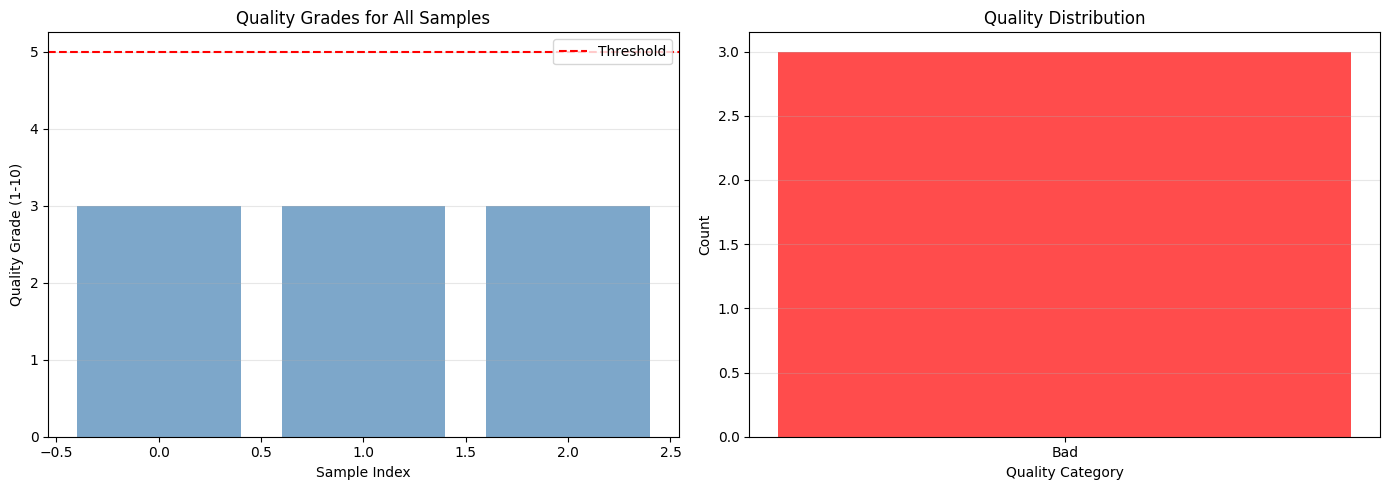


📊 Quality Summary:
  Average Grade: 3.0/10
  Grade Range: 3-3
  Bad: 3 samples


In [154]:
# Cell [19]
# ============================================================================
# PLOT QUALITY GRADES AS BAR CHART
# ============================================================================

if 'all_results' in locals() and all_results:
    quality_results = [r.get("quality") for r in all_results if r.get("quality")]
    
    if quality_results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Grade distribution
        grades = [q["grade"] for q in quality_results]
        qualities = [q["quality"] for q in quality_results]
        
        axes[0].bar(range(len(grades)), grades, color='steelblue', alpha=0.7)
        axes[0].axhline(y=5, color='red', linestyle='--', label='Threshold')
        axes[0].set_xlabel('Sample Index')
        axes[0].set_ylabel('Quality Grade (1-10)')
        axes[0].set_title('Quality Grades for All Samples')
        axes[0].legend()
        axes[0].grid(axis='y', alpha=0.3)
        
        # Quality distribution
        quality_counts = pd.Series(qualities).value_counts()
        colors = {'Bad': 'red', 'Okay': 'orange', 'Good': 'green'}
        bar_colors = [colors.get(q, 'gray') for q in quality_counts.index]
        
        axes[1].bar(quality_counts.index, quality_counts.values, color=bar_colors, alpha=0.7)
        axes[1].set_xlabel('Quality Category')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Quality Distribution')
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Quality Summary:")
        print(f"  Average Grade: {np.mean(grades):.1f}/10")
        print(f"  Grade Range: {min(grades)}-{max(grades)}")
        for quality, count in quality_counts.items():
            print(f"  {quality}: {count} samples")
    else:
        print("❌ No quality results to plot")
else:
    print("❌ No results available. Run Cell [9] first!")

In [155]:
# Cell [20]
# ============================================================================
# PLOT CARDIAC METRICS (FOR CAMUS)
# ============================================================================

if DATASET_TYPE == "CAMUS" and 'all_results' in locals() and all_results:
    # Extract metrics
    patients = [r['patient'] for r in all_results if 'patient' in r]
    edv_values = [r.get('EDV') for r in all_results if r.get('EDV')]
    esv_values = [r.get('ESV') for r in all_results if r.get('ESV')]
    sv_values = [r.get('SV') for r in all_results if r.get('SV')]
    ef_values = [r.get('EF') for r in all_results if r.get('EF')]
    
    if edv_values:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # EDV
        axes[0, 0].bar(range(len(edv_values)), edv_values, color='steelblue', alpha=0.7)
        axes[0, 0].set_title('End-Diastolic Volume (EDV)', fontweight='bold')
        axes[0, 0].set_ylabel('Volume (mL)')
        axes[0, 0].set_xlabel('Patient Index')
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        # ESV
        axes[0, 1].bar(range(len(esv_values)), esv_values, color='coral', alpha=0.7)
        axes[0, 1].set_title('End-Systolic Volume (ESV)', fontweight='bold')
        axes[0, 1].set_ylabel('Volume (mL)')
        axes[0, 1].set_xlabel('Patient Index')
        axes[0, 1].grid(axis='y', alpha=0.3)
        
        # SV
        axes[1, 0].bar(range(len(sv_values)), sv_values, color='mediumseagreen', alpha=0.7)
        axes[1, 0].set_title('Stroke Volume (SV)', fontweight='bold')
        axes[1, 0].set_ylabel('Volume (mL)')
        axes[1, 0].set_xlabel('Patient Index')
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        # EF
        axes[1, 1].bar(range(len(ef_values)), ef_values, color='mediumpurple', alpha=0.7)
        axes[1, 1].axhline(y=50, color='red', linestyle='--', label='Normal threshold')
        axes[1, 1].set_title('Ejection Fraction (EF)', fontweight='bold')
        axes[1, 1].set_ylabel('EF (%)')
        axes[1, 1].set_xlabel('Patient Index')
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        plt.suptitle('Cardiac Functional Metrics', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Cardiac Metrics Summary:")
        print(f"  EDV: {np.mean(edv_values):.1f} ± {np.std(edv_values):.1f} mL")
        print(f"  ESV: {np.mean(esv_values):.1f} ± {np.std(esv_values):.1f} mL")
        print(f"  SV:  {np.mean(sv_values):.1f} ± {np.std(sv_values):.1f} mL")
        print(f"  EF:  {np.mean(ef_values):.1f} ± {np.std(ef_values):.1f}%")

In [156]:
# Cell [20]
# ============================================================================
# PLOT CARDIAC METRICS (FOR CAMUS)
# ============================================================================

if DATASET_TYPE == "CAMUS" and 'all_results' in locals() and all_results:
    # Extract metrics
    patients = [r['patient'] for r in all_results if 'patient' in r]
    edv_values = [r.get('EDV') for r in all_results if r.get('EDV')]
    esv_values = [r.get('ESV') for r in all_results if r.get('ESV')]
    sv_values = [r.get('SV') for r in all_results if r.get('SV')]
    ef_values = [r.get('EF') for r in all_results if r.get('EF')]
    
    if edv_values:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # EDV
        axes[0, 0].bar(range(len(edv_values)), edv_values, color='steelblue', alpha=0.7)
        axes[0, 0].set_title('End-Diastolic Volume (EDV)', fontweight='bold')
        axes[0, 0].set_ylabel('Volume (mL)')
        axes[0, 0].set_xlabel('Patient Index')
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        # ESV
        axes[0, 1].bar(range(len(esv_values)), esv_values, color='coral', alpha=0.7)
        axes[0, 1].set_title('End-Systolic Volume (ESV)', fontweight='bold')
        axes[0, 1].set_ylabel('Volume (mL)')
        axes[0, 1].set_xlabel('Patient Index')
        axes[0, 1].grid(axis='y', alpha=0.3)
        
        # SV
        axes[1, 0].bar(range(len(sv_values)), sv_values, color='mediumseagreen', alpha=0.7)
        axes[1, 0].set_title('Stroke Volume (SV)', fontweight='bold')
        axes[1, 0].set_ylabel('Volume (mL)')
        axes[1, 0].set_xlabel('Patient Index')
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        # EF
        axes[1, 1].bar(range(len(ef_values)), ef_values, color='mediumpurple', alpha=0.7)
        axes[1, 1].axhline(y=50, color='red', linestyle='--', label='Normal threshold')
        axes[1, 1].set_title('Ejection Fraction (EF)', fontweight='bold')
        axes[1, 1].set_ylabel('EF (%)')
        axes[1, 1].set_xlabel('Patient Index')
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        plt.suptitle('Cardiac Functional Metrics', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Cardiac Metrics Summary:")
        print(f"  EDV: {np.mean(edv_values):.1f} ± {np.std(edv_values):.1f} mL")
        print(f"  ESV: {np.mean(esv_values):.1f} ± {np.std(esv_values):.1f} mL")
        print(f"  SV:  {np.mean(sv_values):.1f} ± {np.std(sv_values):.1f} mL")
        print(f"  EF:  {np.mean(ef_values):.1f} ± {np.std(ef_values):.1f}%")

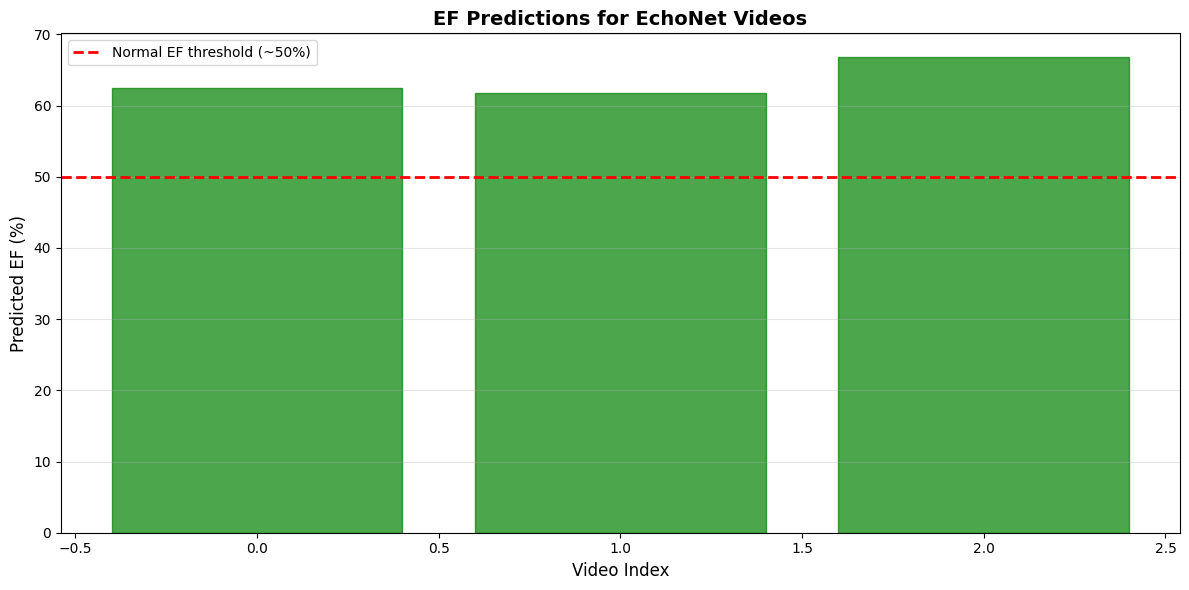


💓 EF Prediction Summary:
  Mean: 63.67%
  Std:  2.22%
  Min:  61.82%
  Max:  66.80%

  Abnormal (EF < 40%): 0
  Borderline (40% ≤ EF < 50%): 0
  Normal (EF ≥ 50%): 3


In [157]:
# Cell [21]
# ============================================================================
# PLOT EF PREDICTIONS (FOR ECHONET)
# ============================================================================

if DATASET_TYPE == "ECHONET" and 'all_results' in locals() and all_results:
    ef_predictions = [r.get('predicted_ef') for r in all_results if r.get('predicted_ef')]
    video_names = [r.get('video', f'Video {i}') for i, r in enumerate(all_results) if r.get('predicted_ef')]
    
    if ef_predictions:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        bars = ax.bar(range(len(ef_predictions)), ef_predictions, color='mediumpurple', alpha=0.7)
        ax.axhline(y=50, color='red', linestyle='--', label='Normal EF threshold (~50%)', linewidth=2)
        ax.set_xlabel('Video Index', fontsize=12)
        ax.set_ylabel('Predicted EF (%)', fontsize=12)
        ax.set_title('EF Predictions for EchoNet Videos', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        # Color code bars
        for i, (bar, ef) in enumerate(zip(bars, ef_predictions)):
            if ef < 40:
                bar.set_color('red')
            elif ef < 50:
                bar.set_color('orange')
            else:
                bar.set_color('green')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n💓 EF Prediction Summary:")
        print(f"  Mean: {np.mean(ef_predictions):.2f}%")
        print(f"  Std:  {np.std(ef_predictions):.2f}%")
        print(f"  Min:  {np.min(ef_predictions):.2f}%")
        print(f"  Max:  {np.max(ef_predictions):.2f}%")
        print(f"\n  Abnormal (EF < 40%): {sum(1 for ef in ef_predictions if ef < 40)}")
        print(f"  Borderline (40% ≤ EF < 50%): {sum(1 for ef in ef_predictions if 40 <= ef < 50)}")
        print(f"  Normal (EF ≥ 50%): {sum(1 for ef in ef_predictions if ef >= 50)}")

Showing comprehensive analysis for first sample:


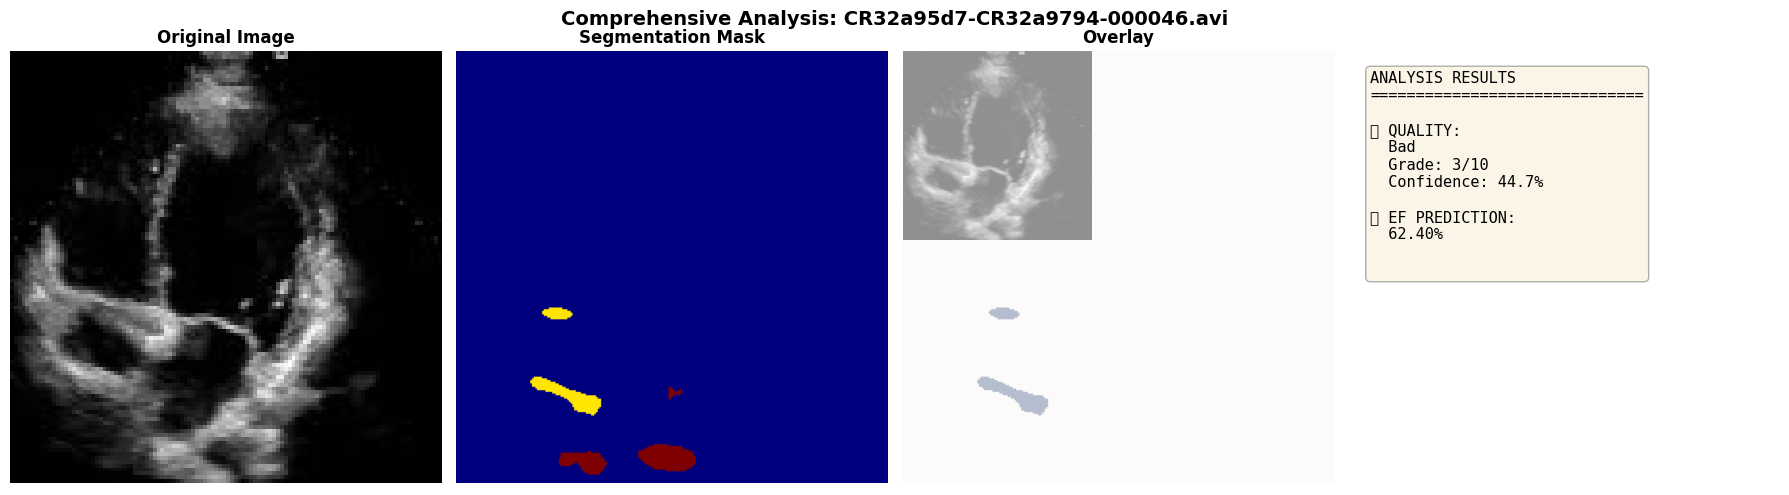


💡 TIP: Change sample_idx to see other samples:
   comprehensive_visualization(sample_idx=1)
   comprehensive_visualization(sample_idx=2)


In [158]:
# Cell [22]
# ============================================================================
# SIDE-BY-SIDE COMPARISON: Original vs Segmentation vs Quality
# ============================================================================

def comprehensive_visualization(sample_idx=0):
    """Show original image, segmentation, and quality assessment side by side"""
    
    if not all_results or sample_idx >= len(all_results):
        print("❌ Invalid sample index")
        return
    
    result = all_results[sample_idx]
    
    # Get image based on dataset type
    if DATASET_TYPE == "CAMUS":
        pid = result['patient']
        img = load_image(pid, "4CH", "ED", CAMUS_DIR)
        title = f"{pid} - 4CH ED"
    elif DATASET_TYPE == "CACTUS":
        img_name = result['image']
        img_path = os.path.join(CACTUS_DIR, "Images Dataset", "A4C", img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        title = img_name
    elif DATASET_TYPE == "ECHONET":
        video_name = result['video']
        video_path = os.path.join(ECHONET_DIR, "Videos", video_name)
        img = extract_frame_from_video(video_path, frame_idx=0)
        title = video_name
    
    if img is None:
        print("❌ Could not load image")
        return
    
    # Create figure
    fig = plt.figure(figsize=(18, 5))
    
    # Original image
    ax1 = plt.subplot(1, 4, 1)
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image', fontweight='bold')
    ax1.axis('off')
    
    # Segmentation
    if seg_model is not None:
        ax2 = plt.subplot(1, 4, 2)
        seg_tensor = preprocess_for_segmentation(img)
        pred_mask = segment_image(seg_model, seg_tensor)
        ax2.imshow(pred_mask, cmap='jet')
        ax2.set_title('Segmentation Mask', fontweight='bold')
        ax2.axis('off')
        
        # Overlay
        ax3 = plt.subplot(1, 4, 3)
        ax3.imshow(img, cmap='gray')
        lv_mask = (pred_mask == 1).astype(float)
        myo_mask = (pred_mask == 2).astype(float)
        ax3.imshow(lv_mask, alpha=0.4, cmap='Reds')
        ax3.imshow(myo_mask, alpha=0.3, cmap='Blues')
        ax3.set_title('Overlay', fontweight='bold')
        ax3.axis('off')
    
    # Info panel
    ax4 = plt.subplot(1, 4, 4)
    ax4.axis('off')
    
    info_text = f"ANALYSIS RESULTS\n{'='*30}\n\n"
    
    # Quality
    if result.get('quality'):
        q = result['quality']
        info_text += f"⭐ QUALITY:\n"
        info_text += f"  {q['quality']}\n"
        info_text += f"  Grade: {q['grade']}/10\n"
        info_text += f"  Confidence: {q['confidence']:.1%}\n\n"
    
    # Cardiac metrics
    if result.get('EF'):
        info_text += f"💓 CARDIAC METRICS:\n"
        info_text += f"  EDV: {result['EDV']:.1f} mL\n"
        info_text += f"  ESV: {result['ESV']:.1f} mL\n"
        info_text += f"  SV: {result['SV']:.1f} mL\n"
        info_text += f"  EF: {result['EF']:.1f}%\n\n"
    
    # EF prediction
    if result.get('predicted_ef'):
        info_text += f"💓 EF PREDICTION:\n"
        info_text += f"  {result['predicted_ef']:.2f}%\n\n"
    
    # Segmentation metrics
    if result.get('segmentation'):
        s = result['segmentation']
        info_text += f"🔍 SEGMENTATION:\n"
        info_text += f"  LV Area: {s['lv_area_mm2']:.1f} mm²\n"
        info_text += f"  LV Length: {s['lv_length_mm']:.1f} mm\n"
    
    ax4.text(0.05, 0.95, info_text, transform=ax4.transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle(f"Comprehensive Analysis: {title}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show comprehensive view for first sample
if 'all_results' in locals() and all_results:
    print("Showing comprehensive analysis for first sample:")
    comprehensive_visualization(sample_idx=0)
    
    print("\n💡 TIP: Change sample_idx to see other samples:")
    print("   comprehensive_visualization(sample_idx=1)")
    print("   comprehensive_visualization(sample_idx=2)")

In [159]:
# Cell [23]
# ============================================================================
# DETAILED RESULTS VIEW WITH QUALITY EMPHASIS
# ============================================================================

if 'all_results' in locals() and all_results:
    print("\n" + "="*70)
    print("📊 DETAILED ANALYSIS RESULTS")
    print("="*70 + "\n")
    
    for idx, result in enumerate(all_results):
        print(f"\n{'='*70}")
        
        # Get identifier
        if 'patient' in result:
            identifier = result['patient']
        elif 'image' in result:
            identifier = result['image']
        elif 'video' in result:
            identifier = result['video']
        else:
            identifier = f"Sample {idx}"
        
        print(f"Sample {idx + 1}: {identifier}")
        print(f"{'='*70}")
        
        # Quality Assessment (MAIN OUTPUT FOR CACTUS)
        if result.get('quality'):
            q = result['quality']
            quality_emoji = {"Bad": "❌", "Okay": "⚠️", "Good": "✅"}
            emoji = quality_emoji.get(q['quality'], "❓")
            
            print(f"\n⭐ IMAGE QUALITY ASSESSMENT:")
            print(f"   {emoji} Quality: {q['quality']}")
            print(f"   📊 Grade: {q['grade']}/10")
            print(f"   🎯 Confidence: {q['confidence']:.1%}")
        else:
            print(f"\n⭐ IMAGE QUALITY ASSESSMENT: Not available")
        
        # Cardiac Metrics (CAMUS only)
        if result.get('EF'):
            print(f"\n💓 CARDIAC METRICS:")
            print(f"   EDV: {result['EDV']:.1f} mL")
            print(f"   ESV: {result['ESV']:.1f} mL")
            print(f"   SV:  {result['SV']:.1f} mL")
            print(f"   EF:  {result['EF']:.1f}%")
        
        # EF Prediction (EchoNet only)
        if result.get('predicted_ef'):
            print(f"\n💓 EF PREDICTION:")
            print(f"   Predicted EF: {result['predicted_ef']:.2f}%")
        
        # Segmentation Metrics (all datasets, but approximate for cross-domain)
        if result.get('segmentation'):
            s = result['segmentation']
            print(f"\n🔍 SEGMENTATION METRICS:")
            print(f"   LV Area: {s['lv_area_mm2']:.1f} mm²")
            print(f"   LV Length: {s['lv_length_mm']:.1f} mm")
            if result['dataset'] != 'CAMUS':
                print(f"   ⚠️  Note: Cross-domain transfer (trained on CAMUS)")
        
        print()
    
    print("="*70)
    print(f"✅ Displayed {len(all_results)} complete analyses")
    print("="*70)
else:
    print("❌ No results available. Run Cell [9] first!")


📊 DETAILED ANALYSIS RESULTS


Sample 1: CR32a95d7-CR32a9794-000046.avi

⭐ IMAGE QUALITY ASSESSMENT:
   ❌ Quality: Bad
   📊 Grade: 3/10
   🎯 Confidence: 44.7%

💓 EF PREDICTION:
   Predicted EF: 62.40%


Sample 2: CR3dca7da-CR3dcaa6a-000042.avi

⭐ IMAGE QUALITY ASSESSMENT:
   ❌ Quality: Bad
   📊 Grade: 3/10
   🎯 Confidence: 40.5%

💓 EF PREDICTION:
   Predicted EF: 61.82%


Sample 3: CR3dcb5a8-CR3dcb8a1-000033.avi

⭐ IMAGE QUALITY ASSESSMENT:
   ❌ Quality: Bad
   📊 Grade: 3/10
   🎯 Confidence: 67.2%

💓 EF PREDICTION:
   Predicted EF: 66.80%

✅ Displayed 3 complete analyses


In [160]:
# Cell [24]
# ============================================================================
# CACTUS QUALITY GRID VISUALIZATION
# ============================================================================

if DATASET_TYPE == "CACTUS" and 'all_results' in locals() and all_results:
    print("\n" + "="*70)
    print("🔍 CACTUS IMAGE QUALITY GRID")
    print("="*70 + "\n")
    
    image_dir = os.path.join(CACTUS_DIR, "Images Dataset", "A4C")
    
    # Create grid of images with quality labels
    n_samples = min(6, len(all_results))
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx in range(n_samples):
        result = all_results[idx]
        img_name = result['image']
        img_path = os.path.join(image_dir, img_name)
        
        # Load and display image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].axis('off')
        
        # Create title with quality info
        if result.get('quality'):
            q = result['quality']
            quality_color = {"Bad": "red", "Okay": "orange", "Good": "green"}
            color = quality_color.get(q['quality'], "black")
            
            title = f"{q['quality']} (Grade: {q['grade']}/10)\nConfidence: {q['confidence']:.1%}"
            axes[idx].set_title(title, fontsize=11, fontweight='bold', color=color, pad=10)
        else:
            axes[idx].set_title(img_name, fontsize=10)
    
    # Hide extra subplots
    for idx in range(n_samples, 6):
        axes[idx].axis('off')
    
    plt.suptitle('CACTUS Image Quality Assessment Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*70)
    print("📊 QUALITY SUMMARY")
    print("="*70)
    
    quality_results = [r['quality'] for r in all_results if r.get('quality')]
    if quality_results:
        grades = [q['grade'] for q in quality_results]
        qualities = [q['quality'] for q in quality_results]
        
        print(f"\nTotal Images Analyzed: {len(quality_results)}")
        print(f"Average Grade: {np.mean(grades):.1f}/10")
        print(f"Grade Range: {min(grades)} - {max(grades)}")
        print(f"\nQuality Distribution:")
        
        quality_counts = pd.Series(qualities).value_counts()
        for quality in ["Good", "Okay", "Bad"]:
            count = quality_counts.get(quality, 0)
            percentage = (count / len(qualities)) * 100
            emoji = {"Bad": "❌", "Okay": "⚠️", "Good": "✅"}[quality]
            print(f"  {emoji} {quality}: {count} images ({percentage:.1f}%)")

else:
    print("Set DATASET_TYPE to 'CACTUS' and run Cell [9] first!")

Set DATASET_TYPE to 'CACTUS' and run Cell [9] first!


In [161]:
# Cell [25]
# ============================================================================
# CARDIAC METRICS COMPARISON CHART
# ============================================================================

if DATASET_TYPE == "CAMUS" and 'all_results' in locals() and all_results:
    
    # Extract data
    patients = [r['patient'] for r in all_results]
    edv = [r['EDV'] for r in all_results]
    esv = [r['ESV'] for r in all_results]
    sv = [r['SV'] for r in all_results]
    ef = [r['EF'] for r in all_results]
    grades = [r['quality']['grade'] for r in all_results if r.get('quality')]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    x_pos = np.arange(len(patients))
    
    # EDV
    axes[0, 0].bar(x_pos, edv, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('End-Diastolic Volume (EDV)', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Volume (mL)', fontsize=12)
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels([p.replace('patient', 'P') for p in patients], rotation=45)
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].axhline(y=np.mean(edv), color='red', linestyle='--', label=f'Mean: {np.mean(edv):.1f}')
    axes[0, 0].legend()
    
    # ESV
    axes[0, 1].bar(x_pos, esv, color='coral', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('End-Systolic Volume (ESV)', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Volume (mL)', fontsize=12)
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels([p.replace('patient', 'P') for p in patients], rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].axhline(y=np.mean(esv), color='red', linestyle='--', label=f'Mean: {np.mean(esv):.1f}')
    axes[0, 1].legend()
    
    # SV
    axes[0, 2].bar(x_pos, sv, color='mediumseagreen', alpha=0.7, edgecolor='black')
    axes[0, 2].set_title('Stroke Volume (SV)', fontsize=14, fontweight='bold')
    axes[0, 2].set_ylabel('Volume (mL)', fontsize=12)
    axes[0, 2].set_xticks(x_pos)
    axes[0, 2].set_xticklabels([p.replace('patient', 'P') for p in patients], rotation=45)
    axes[0, 2].grid(axis='y', alpha=0.3)
    axes[0, 2].axhline(y=np.mean(sv), color='red', linestyle='--', label=f'Mean: {np.mean(sv):.1f}')
    axes[0, 2].legend()
    
    # EF with color coding
    ef_colors = ['green' if e >= 55 else 'orange' if e >= 50 else 'red' for e in ef]
    axes[1, 0].bar(x_pos, ef, color=ef_colors, alpha=0.7, edgecolor='black')
    axes[1, 0].axhline(y=55, color='green', linestyle='--', linewidth=2, label='Normal (≥55%)')
    axes[1, 0].axhline(y=50, color='orange', linestyle='--', linewidth=2, label='Borderline (50%)')
    axes[1, 0].set_title('Ejection Fraction (EF)', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('EF (%)', fontsize=12)
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels([p.replace('patient', 'P') for p in patients], rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].legend()
    
    # Quality Grades
    axes[1, 1].bar(x_pos, grades, color='mediumpurple', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Image Quality Grade', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Grade (1-10)', fontsize=12)
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([p.replace('patient', 'P') for p in patients], rotation=45)
    axes[1, 1].set_ylim(0, 10)
    axes[1, 1].grid(axis='y', alpha=0.3)
    axes[1, 1].axhline(y=np.mean(grades), color='red', linestyle='--', label=f'Mean: {np.mean(grades):.1f}')
    axes[1, 1].legend()
    
    # Summary Statistics Table
    axes[1, 2].axis('off')
    summary_text = f"""
    📊 SUMMARY STATISTICS
    {'='*35}
    
    Cardiac Metrics:
      EDV: {np.mean(edv):.1f} ± {np.std(edv):.1f} mL
      ESV: {np.mean(esv):.1f} ± {np.std(esv):.1f} mL
      SV:  {np.mean(sv):.1f} ± {np.std(sv):.1f} mL
      EF:  {np.mean(ef):.1f} ± {np.std(ef):.1f} %
    
    Quality Assessment:
      Avg Grade: {np.mean(grades):.1f}/10
      Range: {min(grades)}-{max(grades)}
    
    Clinical Interpretation:
      Normal EF: {sum(1 for e in ef if e >= 55)}/{len(ef)}
      Borderline: {sum(1 for e in ef if 50 <= e < 55)}/{len(ef)}
      Reduced: {sum(1 for e in ef if e < 50)}/{len(ef)}
    """
    
    axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes,
                    fontsize=12, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Comprehensive Cardiac Analysis Dashboard', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ Dashboard generated successfully!")

In [162]:
# Cell [26]
# ============================================================================
# EXPORT ALL RESULTS TO CSV
# ============================================================================

if 'all_results' in locals() and all_results:
    
    # Flatten results for CSV export
    export_data = []
    for r in all_results:
        row = {}
        
        # Basic info
        if 'patient' in r:
            row['ID'] = r['patient']
        elif 'image' in r:
            row['ID'] = r['image']
        elif 'video' in r:
            row['ID'] = r['video']
        
        row['Dataset'] = r.get('dataset', 'Unknown')
        
        # Cardiac metrics
        row['EDV_mL'] = r.get('EDV', None)
        row['ESV_mL'] = r.get('ESV', None)
        row['SV_mL'] = r.get('SV', None)
        row['EF_percent'] = r.get('EF', None)
        
        # Calculate CO if available
        if r.get('SV'):
            row['CO_L_min_at_75bpm'] = (r['SV'] * 75) / 1000
        else:
            row['CO_L_min_at_75bpm'] = None
        
        # Quality
        if r.get('quality'):
            row['Quality_Label'] = r['quality']['quality']
            row['Quality_Grade'] = r['quality']['grade']
            row['Quality_Confidence'] = r['quality']['confidence']
        else:
            row['Quality_Label'] = None
            row['Quality_Grade'] = None
            row['Quality_Confidence'] = None
        
        # Segmentation
        if r.get('segmentation'):
            row['LV_Area_mm2'] = r['segmentation']['lv_area_mm2']
            row['LV_Length_mm'] = r['segmentation']['lv_length_mm']
            row['LV_Pixels'] = r['segmentation']['lv_pixels']
        else:
            row['LV_Area_mm2'] = None
            row['LV_Length_mm'] = None
            row['LV_Pixels'] = None
        
        # EF prediction
        row['Predicted_EF_percent'] = r.get('predicted_ef', None)
        
        export_data.append(row)
    
    # Create DataFrame and save
    df = pd.DataFrame(export_data)
    
    # Create results directory
    os.makedirs('results', exist_ok=True)
    
    filename = f"results/{DATASET_TYPE.lower()}_comprehensive_analysis.csv"
    df.to_csv(filename, index=False)
    
    print("="*70)
    print(f"✅ Results exported to: {filename}")
    print("="*70)
    print(f"Total samples: {len(df)}")
    print(f"Columns: {len(df.columns)}")
    print(f"\nColumn names:")
    for col in df.columns:
        print(f"  - {col}")
    
    print("\n📊 Preview of exported data:")
    display(df)
    
else:
    print("❌ No results to export. Run Cell [9] first!")

✅ Results exported to: results/echonet_comprehensive_analysis.csv
Total samples: 3
Columns: 14

Column names:
  - ID
  - Dataset
  - EDV_mL
  - ESV_mL
  - SV_mL
  - EF_percent
  - CO_L_min_at_75bpm
  - Quality_Label
  - Quality_Grade
  - Quality_Confidence
  - LV_Area_mm2
  - LV_Length_mm
  - LV_Pixels
  - Predicted_EF_percent

📊 Preview of exported data:


,ID,Dataset,EDV_mL,ESV_mL,SV_mL,EF_percent,CO_L_min_at_75bpm,Quality_Label,Quality_Grade,Quality_Confidence,LV_Area_mm2,LV_Length_mm,LV_Pixels,Predicted_EF_percent
0,CR32a95d7-CR32a9794-000046.avi,ECHONET,None,None,None,None,None,Bad,3,0.446853,None,None,None,62.395344
1,CR3dca7da-CR3dcaa6a-000042.avi,ECHONET,None,None,None,None,None,Bad,3,0.405227,None,None,None,61.823814
2,CR3dcb5a8-CR3dcb8a1-000033.avi,ECHONET,None,None,None,None,None,Bad,3,0.672001,None,None,None,66.798508


In [163]:
# Cell [27]
# ============================================================================
# ECHONET PEDIATRIC DATASET SETUP GUIDE
# ============================================================================

print("="*70)
print("📥 ECHONET PEDIATRIC DATASET SETUP")
print("="*70)

# Check current status
echonet_base = "/home/users/joshua04/141/data/raw/echonet_pediatric"
a4c_videos = os.path.join(echonet_base, "A4C", "Videos")
psax_videos = os.path.join(echonet_base, "PSAX", "Videos")

print(f"\nCurrent paths:")
print(f"  A4C Videos:  {a4c_videos}")
print(f"  PSAX Videos: {psax_videos}")

# Check for video files
a4c_count = 0
psax_count = 0

if os.path.exists(a4c_videos):
    a4c_count = len([f for f in os.listdir(a4c_videos) if f.endswith('.mp4')])
if os.path.exists(psax_videos):
    psax_count = len([f for f in os.listdir(psax_videos) if f.endswith('.mp4')])

print(f"\nCurrent video counts:")
print(f"  A4C:  {a4c_count} videos")
print(f"  PSAX: {psax_count} videos")

if a4c_count == 0 and psax_count == 0:
    print("\n" + "="*70)
    print("⚠️  NO VIDEOS FOUND - DOWNLOAD REQUIRED")
    print("="*70)
    print("\n📋 DOWNLOAD INSTRUCTIONS:")
    print("\n1. Visit: https://echonet.github.io/pediatric/")
    print("\n2. Click 'Download' and fill out the data use agreement")
    print("\n3. You'll receive a download link via email")
    print("\n4. Download the dataset (it's large - several GB)")
    print("\n5. Extract the videos to the appropriate folders:")
    print(f"     - A4C videos → {a4c_videos}")
    print(f"     - PSAX videos → {psax_videos}")
    
    print("\n" + "="*70)
    print("🔧 ALTERNATIVE: Test with sample videos")
    print("="*70)
    print("\nIf you want to test the system before downloading the full dataset,")
    print("you can create dummy test videos or use any cardiac ultrasound video.")
    print("\nWould you like me to show you how to test with a single video file?")
    
else:
    print("\n✅ Videos found! EchoNet analysis ready.")
    print(f"\nRun Cell [2] and set DATASET_TYPE = 'ECHONET'")

📥 ECHONET PEDIATRIC DATASET SETUP

Current paths:
  A4C Videos:  /home/users/joshua04/141/data/raw/echonet_pediatric/A4C/Videos
  PSAX Videos: /home/users/joshua04/141/data/raw/echonet_pediatric/PSAX/Videos

Current video counts:
  A4C:  0 videos
  PSAX: 0 videos

⚠️  NO VIDEOS FOUND - DOWNLOAD REQUIRED

📋 DOWNLOAD INSTRUCTIONS:

1. Visit: https://echonet.github.io/pediatric/

2. Click 'Download' and fill out the data use agreement

3. You'll receive a download link via email

4. Download the dataset (it's large - several GB)

5. Extract the videos to the appropriate folders:
     - A4C videos → /home/users/joshua04/141/data/raw/echonet_pediatric/A4C/Videos
     - PSAX videos → /home/users/joshua04/141/data/raw/echonet_pediatric/PSAX/Videos

🔧 ALTERNATIVE: Test with sample videos

If you want to test the system before downloading the full dataset,
you can create dummy test videos or use any cardiac ultrasound video.

Would you like me to show you how to test with a single video file?


In [164]:
# Cell [28]
# ============================================================================
# ECHONET FLEXIBLE VIDEO FINDER
# ============================================================================

def find_echonet_videos():
    """Search for any .mp4 files in the echonet directory"""
    echonet_base = "/home/users/joshua04/141/data/raw/echonet_pediatric"
    
    all_videos = []
    
    print("🔍 Searching for video files...")
    
    for root, dirs, files in os.walk(echonet_base):
        for file in files:
            if file.endswith('.mp4'):
                video_path = os.path.join(root, file)
                all_videos.append(video_path)
    
    print(f"\n✅ Found {len(all_videos)} video files")
    
    if len(all_videos) > 0:
        print("\nFirst 10 videos:")
        for i, v in enumerate(all_videos[:10]):
            print(f"  {i+1}. {os.path.basename(v)}")
    
    return all_videos

# Find videos
available_videos = find_echonet_videos()

if len(available_videos) == 0:
    print("\n❌ No video files found in EchoNet directory")
    print("Please download the dataset or add test videos")
else:
    print(f"\n💡 Found {len(available_videos)} videos - ready for analysis!")

🔍 Searching for video files...

✅ Found 0 video files

❌ No video files found in EchoNet directory
Please download the dataset or add test videos


In [165]:
# Cell [29]
# ============================================================================
# TEST WITH A SINGLE VIDEO FILE (ANY PATH)
# ============================================================================

def test_with_custom_video(video_path):
    """Test the system with any video file"""
    
    if not os.path.exists(video_path):
        print(f"❌ Video not found: {video_path}")
        return None
    
    print("="*70)
    print(f"🎥 TESTING WITH: {os.path.basename(video_path)}")
    print("="*70)
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("❌ Could not open video")
        return None
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    
    print(f"\n📊 Video info:")
    print(f"   Frames: {total_frames}")
    print(f"   FPS: {fps:.1f}")
    print(f"   Duration: {total_frames/fps:.1f}s")
    
    # Run all analyses
    result = {"video": os.path.basename(video_path), "dataset": "ECHONET"}
    
    # EF Prediction
    if ef_model is not None:
        try:
            print("\n💓 Predicting EF...")
            video_tensor = read_video_frames_for_ef(video_path, n_frames=16)
            if video_tensor is not None:
                ef_value = predict_ef(ef_model, video_tensor)
                result['predicted_ef'] = ef_value
                print(f"   ✅ Predicted EF: {ef_value:.2f}%")
        except Exception as e:
            print(f"   ❌ Failed: {e}")
    
    # Quality Assessment
    if cactus_model is not None:
        try:
            print("\n⭐ Assessing quality...")
            cap = cv2.VideoCapture(video_path)
            cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
            ret, frame = cap.read()
            cap.release()
            
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                quality_tensor = preprocess_for_quality(frame_rgb)
                quality_result = assess_quality(cactus_model, quality_tensor)
                result['quality'] = quality_result
                print(f"   ✅ Quality: {quality_result['quality']} ({quality_result['grade']}/10)")
        except Exception as e:
            print(f"   ❌ Failed: {e}")
    
    # Segmentation
    if seg_model is not None:
        try:
            print("\n🔍 Running segmentation...")
            frame_gray = extract_frame_from_video(video_path, total_frames // 2)
            if frame_gray is not None:
                seg_tensor = preprocess_for_segmentation(frame_gray)
                pred_mask = segment_image(seg_model, seg_tensor)
                seg_metrics = calculate_metrics_from_mask(pred_mask)
                result['segmentation'] = seg_metrics
                print(f"   ✅ LV Area: {seg_metrics['lv_area_mm2']:.1f} mm²")
        except Exception as e:
            print(f"   ❌ Failed: {e}")
    
    return [result]

# EXAMPLE USAGE:
# Uncomment and replace with your video path
# all_results = test_with_custom_video("/path/to/your/video.mp4")
# Then run Cell 23 to see results

print("💡 To test with a custom video, run:")
print('   all_results = test_with_custom_video("/path/to/video.mp4")')

💡 To test with a custom video, run:
   all_results = test_with_custom_video("/path/to/video.mp4")


In [140]:
# Cell [37]
# ============================================================================
# VERIFY ECHONET VIDEOS WITH NEW PATH
# ============================================================================

print("🔍 Checking EchoNet video path...\n")

echonet_videos_path = os.path.join(ECHONET_DIR, "Videos")

print(f"Looking for videos at: {echonet_videos_path}")
print(f"Absolute path: {os.path.abspath(echonet_videos_path)}")
print()

if os.path.exists(echonet_videos_path):
    print("✅ Videos folder exists!")
    
    video_files = [f for f in os.listdir(echonet_videos_path) if f.endswith('.mp4')]
    
    if video_files:
        print(f"✅ Found {len(video_files)} .mp4 video files!")
        print(f"\nFirst 10 videos:")
        for i, v in enumerate(video_files[:10]):
            print(f"   {i+1}. {v}")
        
        if len(video_files) > 10:
            print(f"   ... and {len(video_files) - 10} more")
        
        print(f"\n🎉 ECHONET IS READY TO USE!")
        print(f"   Set DATASET_TYPE = 'ECHONET' in Cell [2]")
        print(f"   Then run Cell [9]")
    else:
        print("⚠️  Videos folder exists but contains 0 .mp4 files")
        print(f"\nFolder contents:")
        all_files = os.listdir(echonet_videos_path)[:20]
        for f in all_files:
            print(f"   - {f}")
else:
    print(f"❌ Videos folder not found at: {echonet_videos_path}")
    print(f"\n🔍 Let me search for it...")
    
    # Search from current directory
    for root, dirs, files in os.walk("."):
        if "Videos" in dirs:
            full_path = os.path.join(root, "Videos")
            mp4_files = [f for f in os.listdir(full_path) if f.endswith('.mp4')]
            if mp4_files and ('echonet' in root.lower() or 'A4C' in root):
                print(f"\n✅ Found videos at: {full_path}")
                print(f"   Contains {len(mp4_files)} .mp4 files")
                print(f"\n💡 Update ECHONET_DIR in Cell [1] to:")
                print(f'   ECHONET_DIR = "{os.path.dirname(full_path)}"')
                break

🔍 Checking EchoNet video path...

Looking for videos at: /home/users/joshua04/141/data/raw/echonet_pediatric/A4C/Videos
Absolute path: /home/users/joshua04/141/data/raw/echonet_pediatric/A4C/Videos

✅ Videos folder exists!
⚠️  Videos folder exists but contains 0 .mp4 files

Folder contents:
   - CR32a95d7-CR32a9794-000046.avi
   - CR3dca7da-CR3dcaa6a-000042.avi
   - CR3dcb5a8-CR3dcb8a1-000033.avi
   - CR3dca6ca-CR3dca999-000084.avi
   - CR3dcb08a-CR3dcb3e7-000063.avi
   - CR3dca680-CR3dcb712-000154.avi
   - CR32a95e5-CR3dcaeaf-000034.avi
   - CR32a975f-CR3dcb678-000063.avi
   - CR3dcabb4-CR3dcad64-000057.avi
   - CR3dcb0eb-CR3dcb2b5-000078.avi
   - CR3dcafc2-CR3dcb902-000032.avi
   - CR32a9682-CR32a9b23-000021.avi
   - CR32a95fb-CR3dcaaf4-000029.avi
   - CR3dca836-CR3dcab14-000003.avi
   - CR3dcac24-CR3dcae64-000031.avi
   - CR32a757a-CR32a97d2-000018.avi
   - CR32a96dd-CR32a998e-000041.avi
   - CR3dcab5a-CR3dcb91f-000063.avi
   - CR3dcac58-CR3dcaedd-000056.avi
   - CR32a9774-CR32a9b1a

In [141]:
# Cell [38]
# ============================================================================
# THOROUGH SEARCH FOR ECHONET VIDEOS
# ============================================================================

import os

print("🔍 Searching entire home directory for EchoNet videos...\n")

# Search from home directory
home_dir = "/home/users/joshua04"

found_locations = []

for root, dirs, files in os.walk(home_dir):
    # Skip hidden directories and common large directories
    dirs[:] = [d for d in dirs if not d.startswith('.') and d not in ['node_modules', '__pycache__']]
    
    # Look for "Videos" directories
    if "Videos" in dirs:
        videos_path = os.path.join(root, "Videos")
        
        # Check if it has .mp4 files
        try:
            mp4_files = [f for f in os.listdir(videos_path) if f.endswith('.mp4')]
            
            if mp4_files:
                print(f"✅ Found {len(mp4_files)} .mp4 files at:")
                print(f"   {videos_path}")
                
                # Check if it's likely echonet
                if 'echonet' in root.lower() or 'A4C' in root or 'pediatric' in root.lower():
                    print(f"   ⭐ This looks like EchoNet!")
                
                found_locations.append((videos_path, len(mp4_files)))
                print()
        except PermissionError:
            pass

if found_locations:
    print("="*70)
    print(f"📊 SUMMARY: Found {len(found_locations)} location(s) with videos")
    print("="*70)
    
    for path, count in found_locations:
        print(f"\n📁 {path}")
        print(f"   Videos: {count}")
        
        # Extract parent directory for ECHONET_DIR
        parent = os.path.dirname(path)
        print(f"\n💡 To use this location, update Cell [1]:")
        print(f'   ECHONET_DIR = "{parent}"')
else:
    print("="*70)
    print("❌ No video files found")
    print("="*70)
    print("\nPossible reasons:")
    print("1. Videos haven't been downloaded yet")
    print("2. Videos are in a different location")
    print("3. Videos have a different extension (not .mp4)")
    
    print("\n💡 Can you tell me:")
    print("   - Where did you download/extract the EchoNet data?")
    print("   - What's the exact path you mentioned: '141/data/raw/echonet_pediatric/A4C/Videos'")
    print("   - Is this relative to /home/users/joshua04/ or somewhere else?")

🔍 Searching entire home directory for EchoNet videos...

❌ No video files found

Possible reasons:
1. Videos haven't been downloaded yet
2. Videos are in a different location
3. Videos have a different extension (not .mp4)

💡 Can you tell me:
   - Where did you download/extract the EchoNet data?
   - What's the exact path you mentioned: '141/data/raw/echonet_pediatric/A4C/Videos'
   - Is this relative to /home/users/joshua04/ or somewhere else?


In [142]:
# Cell [39]
# ============================================================================
# MANUAL PATH CHECK
# ============================================================================

# Let's manually check the exact path you mentioned
test_paths = [
    "/home/users/joshua04/141/data/raw/echonet_pediatric/A4C/Videos",
    "/home/users/joshua04/data/raw/echonet_pediatric/A4C/Videos",
    "141/data/raw/echonet_pediatric/A4C/Videos",
    "./141/data/raw/echonet_pediatric/A4C/Videos",
    "../141/data/raw/echonet_pediatric/A4C/Videos",
]

print("🔍 Testing common path variations...\n")

for path in test_paths:
    abs_path = os.path.abspath(path)
    exists = os.path.exists(path)
    
    print(f"Path: {path}")
    print(f"Absolute: {abs_path}")
    print(f"Exists: {'✅' if exists else '❌'}")
    
    if exists and os.path.isdir(path):
        contents = os.listdir(path)[:5]
        print(f"Contents (first 5): {contents}")
    
    print()

🔍 Testing common path variations...

Path: /home/users/joshua04/141/data/raw/echonet_pediatric/A4C/Videos
Absolute: /home/users/joshua04/141/data/raw/echonet_pediatric/A4C/Videos
Exists: ✅
Contents (first 5): ['CR32a95d7-CR32a9794-000046.avi', 'CR3dca7da-CR3dcaa6a-000042.avi', 'CR3dcb5a8-CR3dcb8a1-000033.avi', 'CR3dca6ca-CR3dca999-000084.avi', 'CR3dcb08a-CR3dcb3e7-000063.avi']

Path: /home/users/joshua04/data/raw/echonet_pediatric/A4C/Videos
Absolute: /home/users/joshua04/data/raw/echonet_pediatric/A4C/Videos
Exists: ❌

Path: 141/data/raw/echonet_pediatric/A4C/Videos
Absolute: /home/users/joshua04/141/141/data/raw/echonet_pediatric/A4C/Videos
Exists: ❌

Path: ./141/data/raw/echonet_pediatric/A4C/Videos
Absolute: /home/users/joshua04/141/141/data/raw/echonet_pediatric/A4C/Videos
Exists: ❌

Path: ../141/data/raw/echonet_pediatric/A4C/Videos
Absolute: /home/users/joshua04/141/data/raw/echonet_pediatric/A4C/Videos
Exists: ✅
Contents (first 5): ['CR32a95d7-CR32a9794-000046.avi', 'CR3dca7da-

In [143]:
# Cell [41]
# ============================================================================
# VERIFY ECHONET .AVI FILES
# ============================================================================

print("🔍 Checking for EchoNet .avi files...\n")

video_dir = os.path.join(ECHONET_DIR, "Videos")

if os.path.exists(video_dir):
    # Check for .avi files
    avi_files = [f for f in os.listdir(video_dir) if f.endswith('.avi')]
    
    # Also check for .mp4 just in case
    mp4_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    
    print(f"📁 Directory: {video_dir}")
    print(f"✅ .avi files: {len(avi_files)}")
    print(f"   .mp4 files: {len(mp4_files)}")
    
    if avi_files:
        print(f"\n🎉 ECHONET IS READY!")
        print(f"\nFirst 5 videos:")
        for i, v in enumerate(avi_files[:5]):
            print(f"   {i+1}. {v}")
        
        print(f"\n✅ Set DATASET_TYPE = 'ECHONET' in Cell [2] and run Cell [9]!")
    else:
        print("\n⚠️  No video files found")
else:
    print(f"❌ Directory not found: {video_dir}")

🔍 Checking for EchoNet .avi files...

📁 Directory: /home/users/joshua04/141/data/raw/echonet_pediatric/A4C/Videos
✅ .avi files: 3284
   .mp4 files: 0

🎉 ECHONET IS READY!

First 5 videos:
   1. CR32a95d7-CR32a9794-000046.avi
   2. CR3dca7da-CR3dcaa6a-000042.avi
   3. CR3dcb5a8-CR3dcb8a1-000033.avi
   4. CR3dca6ca-CR3dca999-000084.avi
   5. CR3dcb08a-CR3dcb3e7-000063.avi

✅ Set DATASET_TYPE = 'ECHONET' in Cell [2] and run Cell [9]!
